# Problem Nonogram

From CSPLib: Nonograms are a popular puzzle, which goes by different names in different countries. Solvers have to shade in squares in a grid so that blocks of consecutive shaded squares satisfy constraints given for each row and column. Constraints typically indicate the sequence of shaded blocks (e.g. 3,1,2 means that there is a block of 3, then a gap of unspecified size, a block of length 1, another gap, and then a block of length 2). Below, there is an example (taken from Chapter 14 in Gecode documentation):

Puzzle:
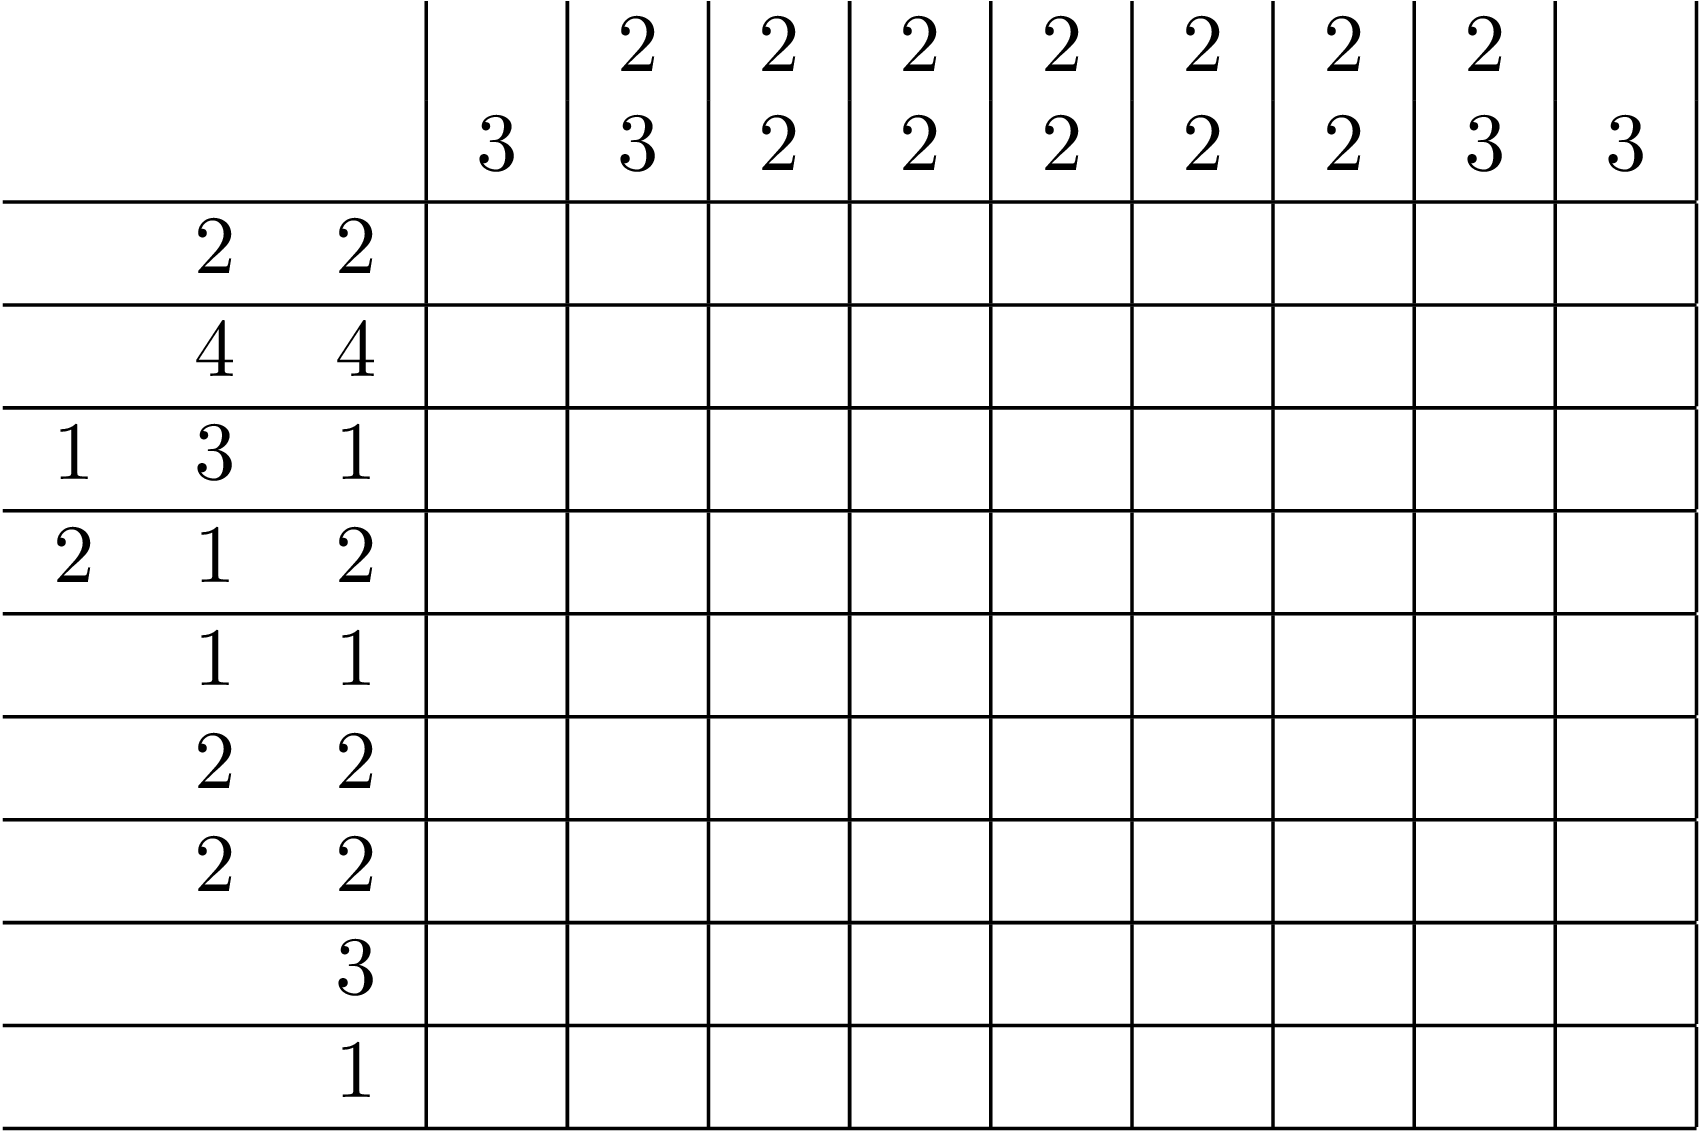

Solution:
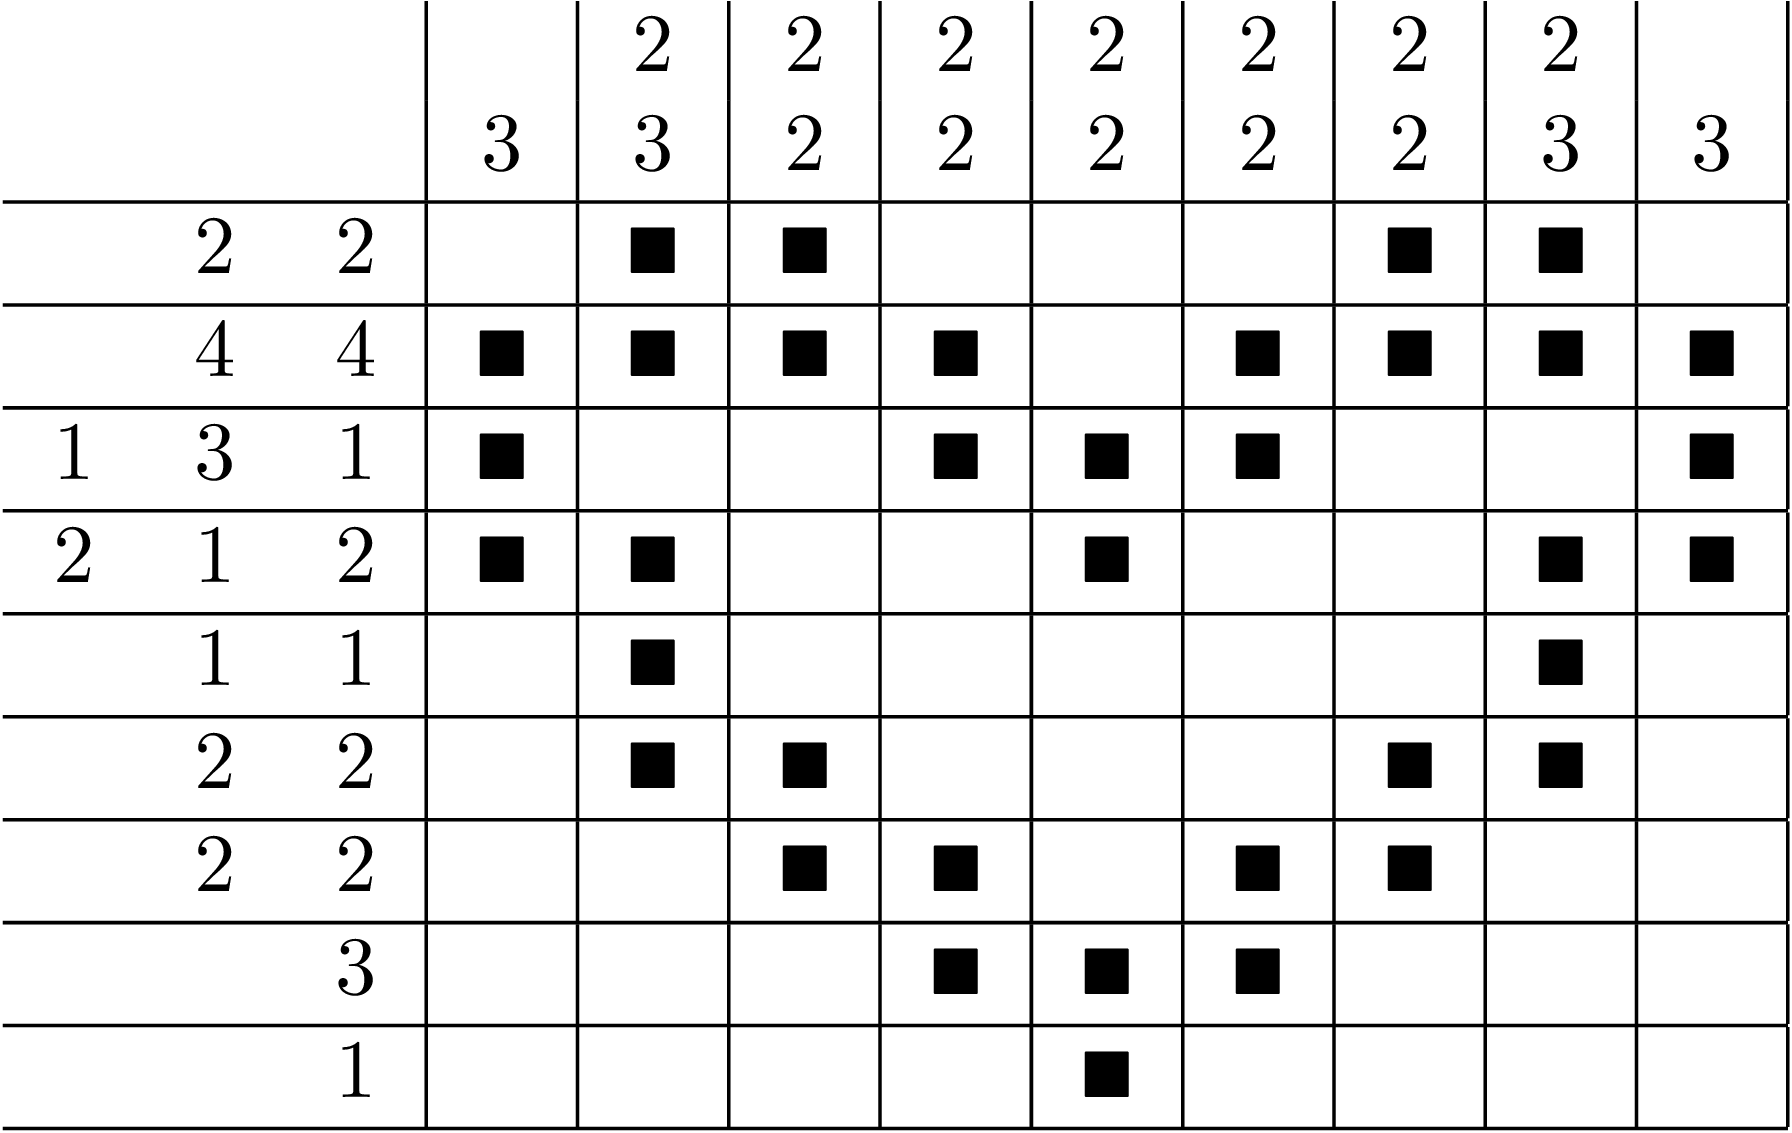

To build a CSP (Constraint Satisfaction Problem) model, we need first to import the library PyCSP$^3$:

In [1]:
from pycsp3 import *

Suppose that the data (for a specific Nonogram puzzle) are initially given in a text file as follows:
- a line stating the numbers of rows and columns,
- then, for each row a line stating the number of blocks followed by the sizes of all these blocks (on the same line),
- then, for each column a line stating the number of blocks followed by the sizes of all these blocks (on the same line).

```
9 9
2  2 2
2  4 4
3  1 3 1
3  2 1 2
2  1 1
2  2 2
2  2 2
1  3
1  1

1  3
2  2 3
2  2 2
2  2 2
2  2 2
2  2 2
2  2 2
2  2 3
1  3
```

It is possible to loas such a file, for example with:
```
from pycsp3.problems.data.parsing import register_fields, next_int

register_fields("https://www.cril.univ-artois.fr/~lecoutre/heart.txt")

nRows, nCols = next_int(), next_int()
rows = [[next_int() for _ in range(next_int())] for _ in range(nRows)]
cols = [[next_int() for _ in range(next_int())] for _ in range(nRows)]
```

However, here, we will consider a JSON file. Actually, this file can be found [here](https://www.cril.univ-artois.fr/~lecoutre/heart.json). To load block patterns, we can then execute: 

In [2]:
rows, cols = default_data("https://www.cril.univ-artois.fr/~lecoutre/heart.json")
nRows, nCols = len(rows), len(cols)

URLError: <urlopen error [Errno 104] Connection reset by peer>

We can check data:

In [ ]:
print("Patterns for rows: ", rows)
print("Patterns for columns: ", cols)

We start our CSP model with a two-dimensional array $x$ of variables, each variable having {0,1} as domain. 

In [ ]:
# x[i][j] is 1 iff the cell at row i and col j is colored in black
x = VarArray(size=[nRows, nCols], dom={0, 1})

We can display (the structure of) the array as well as the domain of the first variable.

In [ ]:
print("Array of variables x: ", x)
print("Domain of any variable: ", x[0][0].dom)

We need to post a constraint *Regular* per row and per column. Indeed, one can transform any clue (pattern for a row or column) into an automaton. We use this function:

In [ ]:
def automaton(pattern):
    q = Automaton.q  # for building state names
    transitions = []
    if len(pattern) == 0:
        n_states = 1
        transitions.append((q(0), 0, q(0)))
    else:
        n_states = sum(pattern) + len(pattern)
        num = 0
        for i, size in enumerate(pattern):
            transitions.append((q(num), 0, q(num)))
            transitions.extend((q(num + j), 1, q(num + j + 1)) for j in range(size))
            transitions.append((q(num + size), 0, q(num + size + (1 if i < len(pattern) - 1 else 0))))
            num += size + 1
    return Automaton(start=q(0), final=q(n_states - 1), transitions=transitions)


For example, if we display the automaton corresponding to the clue (2 2) given for the first row, we can check that the automaton is well built. 

In [ ]:
print(automaton(rows[0]))

We can now post the constraints *Regular*:

In [ ]:
satisfy(
    [x[i] in automaton(rows[i]) for i in range(nRows)],

    [x[:,j] in automaton(cols[j]) for j in range(nCols)]
);

Interestingly, by calling the function *solve()*, we can check that the problem is satisfiable (SAT). We can also display the found solution. Here, we call the function *values()* that collects the values assigned to a specified list of variables.

In [ ]:
if solve() is SAT:
    print(values(x))

We can improve the output:

In [ ]:
if solve() is SAT:
    for i in range(nRows):
        print(' '.join('*' if value(x[i][j]) == 1 else ' ' for j in range(nCols)))

Finally, we give below the model in one piece. Here the data is expected to be given by the user (in a command line).